In [3]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('../peptidome.mplstyle')

import sys
sys.path.append('..')
from lib import *

%load_ext autoreload

In [4]:
df = load_unirefproteome_as_df_path(datadir + 'human-viruses-uniref90.fasta')
df['length'] = df['Sequence'].str.len()
df.sort_values('length', ascending=False, inplace=True)
df = df[~df['header'].str.contains('(Fragment)')]

/home/amayer/miniconda3/envs/min/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


<AxesSubplot:>

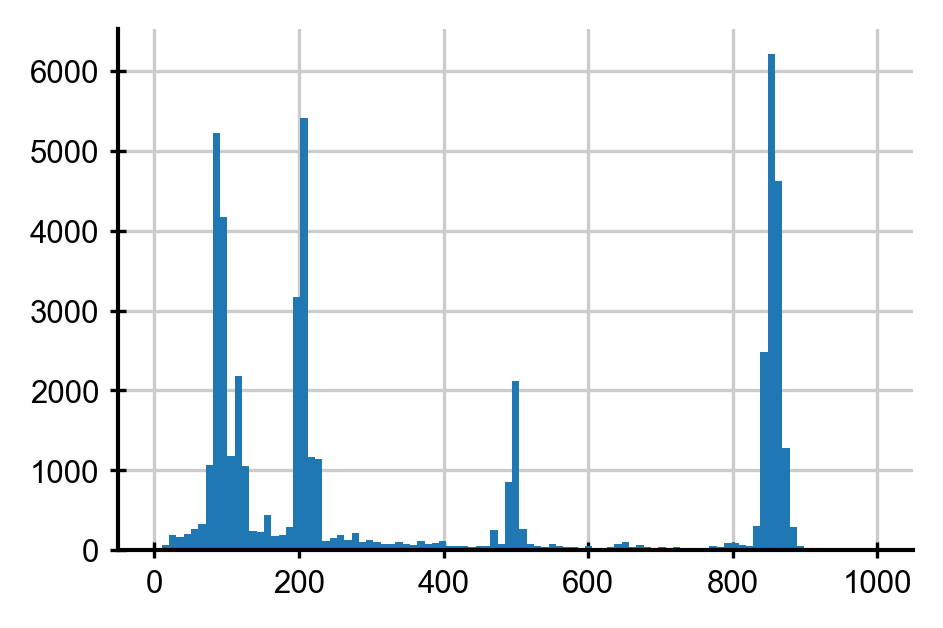

In [8]:
df['length'].hist(bins=np.linspace(0, 1000, 100))

In [ ]:
df['TaxID_species'] = df['TaxID'].apply(normalize_taxid)

In [ ]:
def parse_protein_name(header):
    m = re.search('(?<=\s).+(?=\sn\=)', header)
    if m:
         return m.group(0)
    return ''

In [ ]:
df['Protein name'] = df.apply(lambda row: parse_protein_name(row['header']), axis=1)

In [ ]:
df['TaxID_species'].value_counts().head(20)

In [ ]:
df = df[~(df['TaxID_species']=='')]

In [ ]:
len(set(df['TaxID'].unique())), len(set(df['TaxID_species'].unique()))

In [ ]:
plt.hist(np.log10(df['TaxID_species'].value_counts()))

In [ ]:
def counter_to_series(counter):
    count_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    count_series = count_df.T.squeeze()
    return count_series
def fraction_multiple(series):
    return np.sum(series[series>1])/np.sum(series)

In [ ]:
k = 9
filterlength = 12

In [ ]:
count_series = counter_to_series(count_kmers_iterable(df['Sequence'], k, clean=True))
fraction_multiple(count_series)

In [ ]:
filtered = df.groupby(['TaxID_species', 'Protein name']).head(1)

In [ ]:
def to_kmers_nonoverlapping(seqs, k):
    for seq in seqs:
        for i in range((len(seq)-k+1)//k):
            s = seq[k*i:k*(i+1)]
            if isvalidaa(s):
                yield s

In [ ]:
df = load_unirefproteome_as_df_path(datadir + 'human-viruses-uniref90.fasta')
df['length'] = df['Sequence'].str.len()
df['TaxID_species'] = df['TaxID'].apply(normalize_taxid)
df = df[~(df['TaxID_species']=='')]
df['Protein name'] = df.apply(lambda row: parse_protein_name(row['header']), axis=1)
df = df[~df['header'].str.contains('(Fragment)')]
df = df.sample(frac=1)

In [ ]:
frag_filtered = df.groupby(['TaxID_species', 'Protein name']).head(10)
#frag_filtered = df.groupby(['TaxID_species']).head(200)
fragmentlength = 30
fragments = [kmer for kmer in to_kmers_nonoverlapping(frag_filtered['Sequence'], fragmentlength)]
df_fragments = pd.DataFrame(dict(identifier=[str(i) for i in range(len(fragments))],
                                 Sequence=fragments))
df_fragments.drop_duplicates('Sequence', inplace=True)
'%e'% np.sum(df_fragments['Sequence'].str.len())

In [ ]:
write_fasta(df_fragments, 'virus_fragments.fasta.gz', seqcolumn='Sequence', idcolumn='identifier')

In [ ]:
!mmseqs easy-cluster virus_fragments.fasta.gz virus_fragments_50 tmp --min-seq-id 0.5 -c 0.8 --cov-mode 0 --comp-bias-corr 0

In [ ]:
df_fragments_clustered = load_proteome_as_df_path('virus_fragments_50_rep_seq.fasta',
                                                  parse_genes=False, parse_accessions=False)
print('fragment clustered length', '%e'%np.sum(df_fragments_clustered['Sequence'].str.len()))

In [ ]:
#write_fasta(filtered, datadir+'human-viruses-uniref90-filtered.fasta',
#            seqcolumn='Sequence', descriptioncolumn='header')

In [ ]:
for d in [filtered, df_fragments_clustered]:
    count_series = counter_to_series(count_kmers_iterable(d['Sequence'], k, clean=True))
    count_series_unique = counter_to_series(
                       count_kmers_iterable(
                           filter_unique(d['Sequence'], k, filterlength),
                           k)
                       )
    print(fraction_multiple(count_series), fraction_multiple(count_series_unique),
          '{:.3e}, {:.3e}'.format(np.sum(count_series), np.sum(count_series_unique)))

In [ ]:
count_series.sort_values().tail(10)

In [ ]:
counts, bins, _ = plt.hist(count_series_filtered, log=True,
                           bins=np.arange(0, count_series_filtered.max()+1, 1+count_series_filtered.max()//1000));
plt.hist(count_series_filtered_unique, log=True, bins=bins);
plt.xscale('log')